 Imports

In [1]:
import numpy as np
import pandas as pd
import genData
import matplotlib as mpl
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

%matplotlib inline

Load our data sets for consistant and reproducible results

In [2]:
plt.style.use("seaborn")
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

In [3]:
seed = 637120123
testDataSeed = 781264812
genData.def_seed = seed

In [4]:
trainA = genData.create_A()
testA = genData.create_A(seed=testDataSeed)
trainA

,x,y,target
0,30.82,35.11,1
1,88.38,-90.20,-1
2,34.61,-38.24,-1
3,-71.51,-59.71,-1
4,-73.85,57.25,1
...,...,...,...
995,-93.37,22.69,1
996,73.80,95.16,1
997,-58.18,63.26,1
998,-92.76,-41.66,-1


In [5]:
trainB = genData.create_B(size=1000)
testB = genData.create_B(seed=testDataSeed,size=1000)

train_extra = {"x":[],"y":[],"target":[]}
test_extra = {"x":[],"y":[],"target":[]}


while len(train_extra["target"]) < 30 or len(test_extra["target"])<30:
    train_x = np.random.randint(-300,301)
    train_y = np.random.randint(-300,301)
    test_x = np.random.randint(-300,301)
    test_y = np.random.randint(-300,301)
    
    if 40000 <= train_x**2 + train_y**2 and train_x**2 + train_y**2 <= 90000:
        train_extra["x"].append(train_x/100)
        train_extra["y"].append(train_y/100)
        train_extra["target"].append(1)
    if 40000 <= test_x**2 + test_y**2 and test_x**2 + test_y**2 <= 90000:
        test_extra["x"].append(test_x/100)
        test_extra["y"].append(test_y/100)
        test_extra["target"].append(1)

train_extra = pd.DataFrame(train_extra)
trainB = trainB.append(train_extra,ignore_index=True).sample(frac=1).reset_index(drop=True)

test_extra = pd.DataFrame(test_extra)
testB = testB.append(test_extra,ignore_index=True)

trainB

,x,y,target
0,62.54,-46.18,-1
1,95.29,-49.97,-1
2,37.15,-92.26,-1
3,-83.24,-98.22,-1
4,-41.46,-96.32,-1
...,...,...,...
1025,73.20,40.96,-1
1026,4.02,-27.48,-1
1027,-98.82,-99.54,-1
1028,-91.85,-70.14,-1


## Adaline Model

In [6]:
class Adaline:
    def __init__(self,seed:int = None, learning_rate:float=0.00001, bias:float=0.2, repeats:int=10000, possible_targets=None,epsilon=0.00000001, activationFunction=lambda x: 1 if x>= 0 else -1):
        self.rng = np.random.RandomState(seed)
        self.repeats = repeats
        self.learning_rate = learning_rate
        self.bias = bias
        self.possible_targets = possible_targets
        self.epsilon = epsilon
        self.activationFunction = activationFunction
        

    def fit(self,data,target,verbose:int=0,precision:int=4,max_step:int=10,logRate:int=5) -> dict:
        
        self.weights = self.rng.rand(data.shape[1],1)
        
        
        #make sure we are using a numpy array of shape (fetures, samples)
        if isinstance(data,pd.DataFrame):
            data = data.to_numpy().T
        
        #logging
        past_MSE = [float("inf")]

        #save each epoch
        stats = {"Epoch":[],"bias":[],"MSE":[]}
        for feature_i in range(data.shape[0]):
            stats["w_"+str(feature_i)] = []
            stats["deltaW_"+str(feature_i)] = []
        

        #make sure we don't enter an infinite loop if our model doesn't converge
        for i in range(self.repeats):
            errors = []
            
            #repeat for all data samples
            for x_i in range(data.shape[1]):
                #sum(w_i*x_i) for all features 
                Y = self.bias + np.sum(data[:,[x_i]]*self.weights,axis=0)[0]
                pred = 0
                pred = self.activationFunction(Y)

                delta = 0
                #adjust weights and bias if we guessed wrong
                if pred != target[x_i]:
                    delta = (target[x_i]-Y)
                    deltaW = self.learning_rate*delta*data[:,[x_i]]
                
                    self.weights = self.weights + deltaW
                    self.bias = self.bias+self.learning_rate*delta
                    
                #squared error 
                errors.append((delta**2))
                
            if len(errors) == 0:
                break
            mse = sum(errors)/len(errors)
            past_MSE.append(mse)

            if i%logRate == 0:
                #save stats of each value in our data
                stats["bias"].append(round(self.bias,precision))
                stats["MSE"].append(round(mse,precision))
                stats["Epoch"].append(i)
                for feature_i in range(data.shape[0]):
                    stats["w_"+str(feature_i)].append(round(self.weights[feature_i][0],precision))
                    stats["deltaW_"+str(feature_i)].append(round(deltaW[feature_i][0],precision))
            
            #print stats
            if verbose>=1 and i%logRate == 0:
                print("Epoch",i)
                print(mse)
                print("errors:",len([err for err in errors if err>0]))
                if verbose>=2:
                    df = pd.DataFrame(stats)
                    print(df)
                print("--------")

            #stop if our mse is not changing at all
            if len(past_MSE) > max_step and all(abs(past_MSE[-1] - x)<self.epsilon for x in past_MSE[-max_step:]):
                break
        
        model_performance = pd.DataFrame(stats)
        return model_performance


    def predict(self,data):
        #make sure we are using a numpy array of shape (fetures, samples)
        if isinstance(data,pd.DataFrame):
            data = data.to_numpy().T
        
        #get vector of predicted target values
        raw_target = np.ravel(self.bias+np.sum(data*self.weights,axis=0))
        target = []
        for Y in raw_target:
            target.append(self.activationFunction(Y))
        return np.array(target)

## Part A

In [7]:
ad = Adaline(seed, bias=0.1,learning_rate=0.0001)
perfomance = ad.fit(trainA.loc[:,["x","y"]],trainA["target"],verbose=1, logRate = 10)

Epoch 0
2.6683190620834076
errors: 14
--------
Epoch 10
0.02089836842632647
errors: 6
--------
Epoch 20
0.020550389051494557
errors: 6
--------
Epoch 30
0.02020820000783398
errors: 6
--------
Epoch 40
0.0198717051855464
errors: 6
--------
Epoch 50
0.01954081006786673
errors: 6
--------
Epoch 60
0.019215421704677674
errors: 6
--------
Epoch 70
0.01889544868656132
errors: 6
--------
Epoch 80
0.01858080111928019
errors: 6
--------
Epoch 90
0.018271390598680874
errors: 6
--------
Epoch 100
0.017967130186013227
errors: 6
--------
Epoch 110
0.01766793438365804
errors: 6
--------
Epoch 120
0.01737371911125678
errors: 6
--------
Epoch 130
0.017084401682236437
errors: 6
--------
Epoch 140
0.01679990078072304
errors: 6
--------
Epoch 150
0.016520136438837513
errors: 6
--------
Epoch 160
0.016245030014367303
errors: 6
--------
Epoch 170
0.01597450416880785
errors: 6
--------
Epoch 180
0.015708482845767507
errors: 6
--------
Epoch 190
0.015446891249730097
errors: 6
--------
Epoch 200
0.01518965582

### Model preformance

Text(0, 0.5, 'weight')

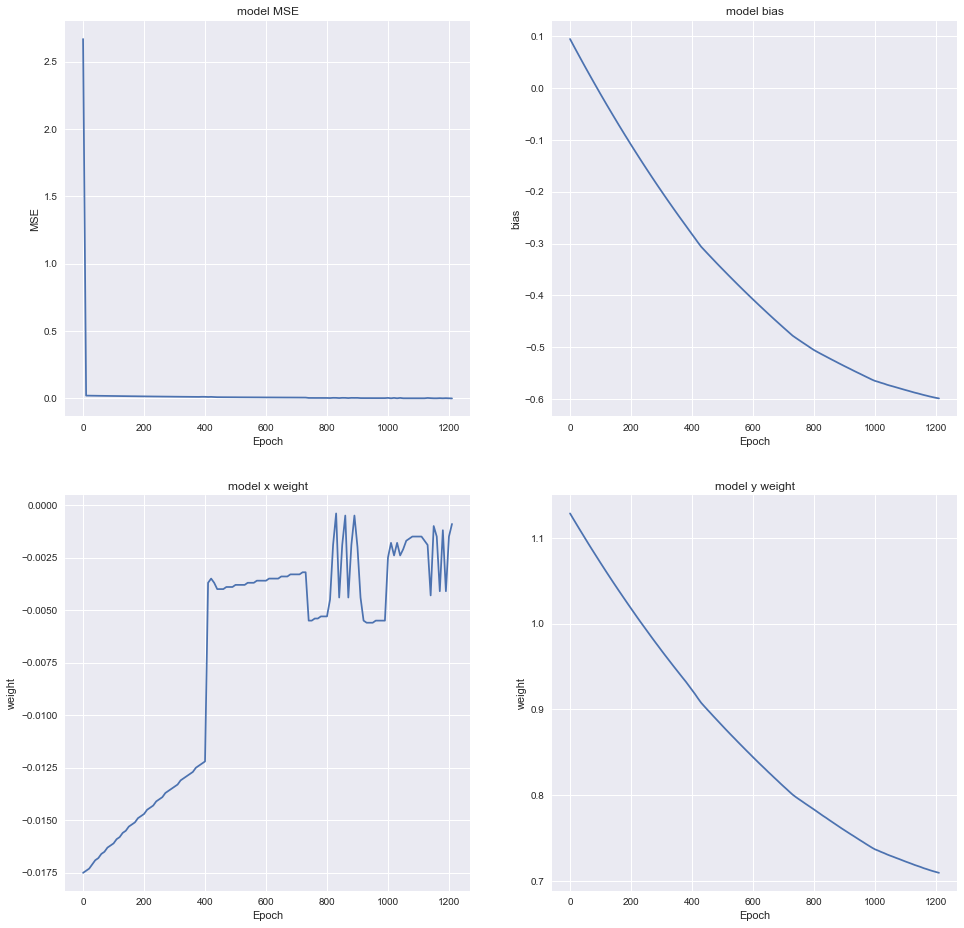

In [8]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(16,16))

ax1.plot(perfomance["Epoch"],perfomance["MSE"])
ax1.set_title("model MSE")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("MSE")

ax2.plot(perfomance["Epoch"],perfomance["bias"])
ax2.set_title("model bias")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("bias")

ax3.plot(perfomance["Epoch"],perfomance["w_0"])
ax3.set_title("model x weight")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("weight")


ax4.plot(perfomance["Epoch"],perfomance["w_1"])
ax4.set_title("model y weight")
ax4.set_xlabel("Epoch")
ax4.set_ylabel("weight")



We can clearly see that our model understands that the x value doesn't matter and so, the weight of the paramater is aproaching 0

In [9]:
testA_res = ad.predict(testA.loc[:,["x","y"]])
accuracy_score(testA["target"],testA_res)

1.0

In [10]:
testA["results"] = testA_res

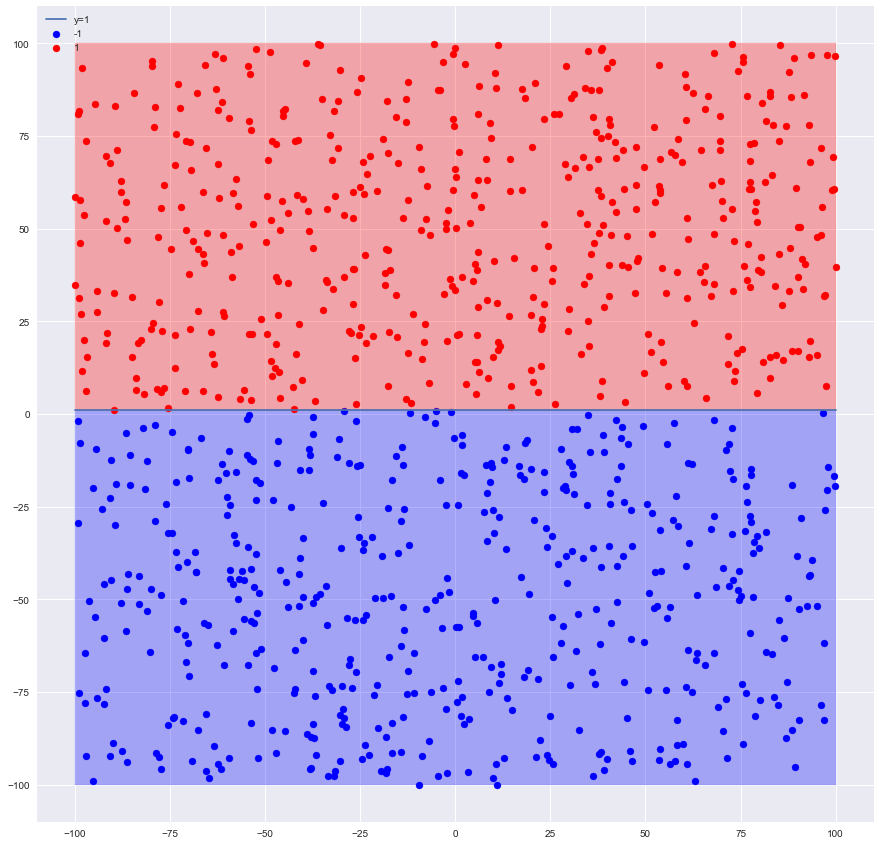

In [11]:
targets_1 = testA[testA["results"] == 1]
targets_neg_1 = testA[testA["results"] != 1]

plt.figure(figsize=(15,15))
plt.plot(np.arange(-100,101),np.ones(201), label="y=1")
plt.fill_between(np.arange(-100,101),np.ones(201),y2=-100*np.ones(201), alpha=0.3, color='b')
plt.scatter(targets_neg_1["x"],targets_neg_1["y"], c='b',label="-1")

plt.fill_between(np.arange(-100,101),np.ones(201),y2=100*np.ones(201), alpha=0.3, color='r')
plt.scatter(targets_1["x"],targets_1["y"], c='r',label="1")
plt.legend()

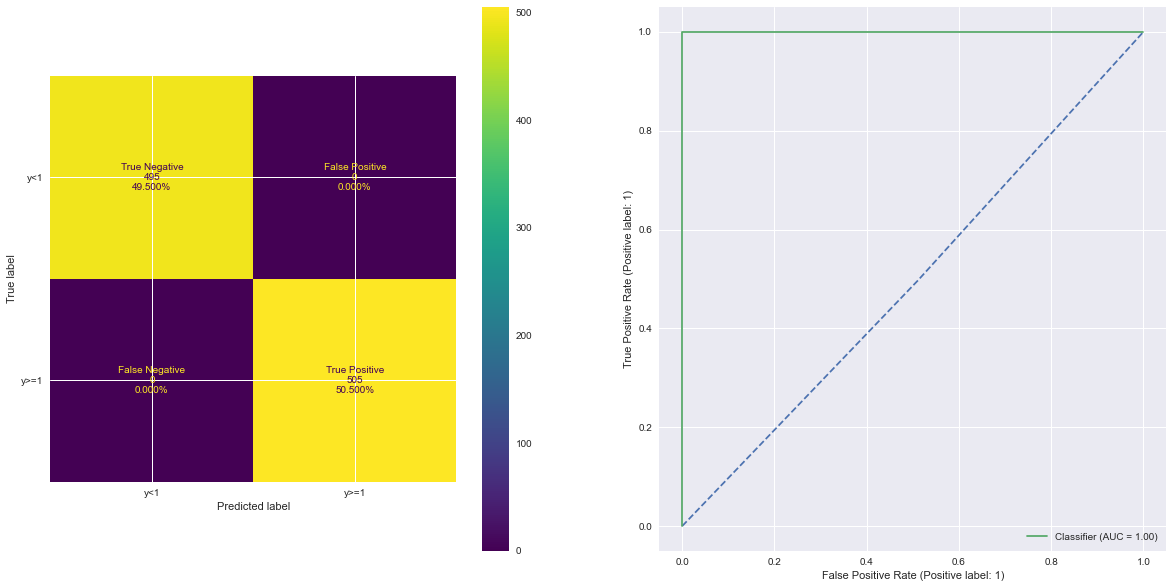

In [12]:
genData.plot_model_results(testA["target"],testA["results"],labels=["y<1","y>=1"])

In [13]:
trainX = trainB.loc[:,["x","y"]]
trainY = trainB["target"]

testX = testB.loc[:,["x","y"]]
testY = testB["target"]

In [14]:
activationFunction = lambda x: 1 if abs(x)<=1 else -1
ad2 = Adaline(seed,bias=0.35,learning_rate=0.000025,repeats=1000,activationFunction=activationFunction)
perfomance2 = ad2.fit(trainX, trainY, logRate = 10,verbose=1,precision=10)

Epoch 0
0.18187178508601592
errors: 35
--------
Epoch 10
0.1695911305350733
errors: 34
--------
Epoch 20
0.16271551263870948
errors: 34
--------
Epoch 30
0.15618227838650567
errors: 34
--------
Epoch 40
0.14998067752802835
errors: 34
--------
Epoch 50
0.14409024799627912
errors: 35
--------
Epoch 60
0.138498464582652
errors: 35
--------
Epoch 70
0.1294929833299237
errors: 34
--------
Epoch 80
0.12469793328847507
errors: 34
--------
Epoch 90
0.11632639806846491
errors: 33
--------
Epoch 100
0.11223835302720503
errors: 34
--------
Epoch 110
0.108352729872228
errors: 34
--------
Epoch 120
0.10466145614940522
errors: 35
--------
Epoch 130
0.10116167029298939
errors: 35
--------
Epoch 140
0.09783791567229384
errors: 35
--------
Epoch 150
0.09468140094251296
errors: 35
--------
Epoch 160
0.09168367580352361
errors: 35
--------
Epoch 170
0.08883671714096185
errors: 35
--------
Epoch 180
0.08613290743630284
errors: 35
--------
Epoch 190
0.08356501426776454
errors: 35
--------
Epoch 200
0.08112

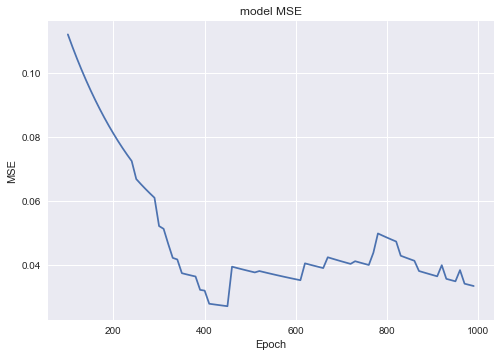

In [15]:
plt.plot(perfomance2["Epoch"][10:],perfomance2["MSE"][10:])
plt.title("model MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

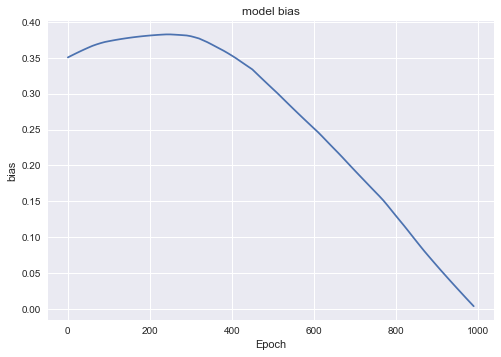

In [16]:
plt.plot(perfomance2["Epoch"],perfomance2["bias"])
plt.title("model bias")
plt.xlabel("Epoch")
plt.ylabel("bias")
plt.show()

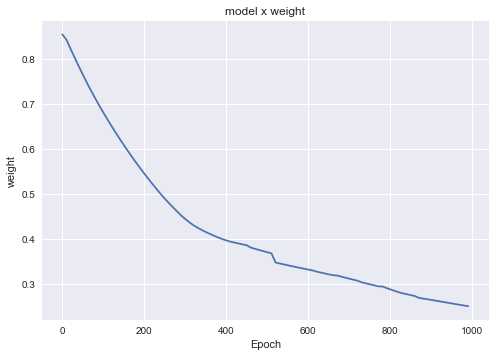

In [17]:
plt.plot(perfomance2["Epoch"],perfomance2["w_0"])
plt.title("model x weight")
plt.xlabel("Epoch")
plt.ylabel("weight")
plt.show()

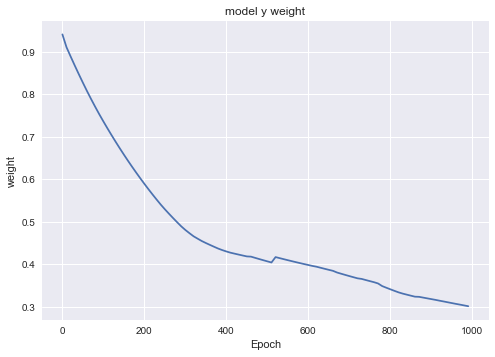

In [18]:
plt.plot(perfomance2["Epoch"],perfomance2["w_1"])
plt.title("model y weight")
plt.xlabel("Epoch")
plt.ylabel("weight")
plt.show()

In [19]:
perfomance2["MSE"].idxmax()

0

In [20]:
testB_res = ad2.predict(testX)
testB_res

array([-1, -1, -1, ..., -1,  1,  1])

In [21]:
accuracy_score(testY,testB_res)

0.9641819941916747

In [22]:
for r in perfomance2.iterrows():
    print(r[1])

Epoch       0.000000
bias        0.350329
MSE         0.181872
w_0         0.854356
deltaW_0    0.000017
w_1         0.940930
deltaW_1   -0.000215
Name: 0, dtype: float64
Epoch       10.000000
bias         0.353199
MSE          0.169591
w_0          0.842316
deltaW_0     0.000017
w_1          0.910765
deltaW_1    -0.000209
Name: 1, dtype: float64
Epoch       20.000000
bias         0.356027
MSE          0.162716
w_0          0.822180
deltaW_0     0.000016
w_1          0.889075
deltaW_1    -0.000205
Name: 2, dtype: float64
Epoch       30.000000
bias         0.358768
MSE          0.156182
w_0          0.802551
deltaW_0     0.000016
w_1          0.867921
deltaW_1    -0.000201
Name: 3, dtype: float64
Epoch       40.000000
bias         0.361416
MSE          0.149981
w_0          0.783443
deltaW_0     0.000016
w_1          0.847271
deltaW_1    -0.000197
Name: 4, dtype: float64
Epoch       50.000000
bias         0.363968
MSE          0.144090
w_0          0.764819
deltaW_0     0.000015
w_1    

In [23]:
testY.value_counts()

-1    1000
 1      33
Name: target, dtype: int64

In [24]:
testB["results"] = testB_res

In [25]:
testB["results"].value_counts()

-1    971
 1     62
Name: results, dtype: int64

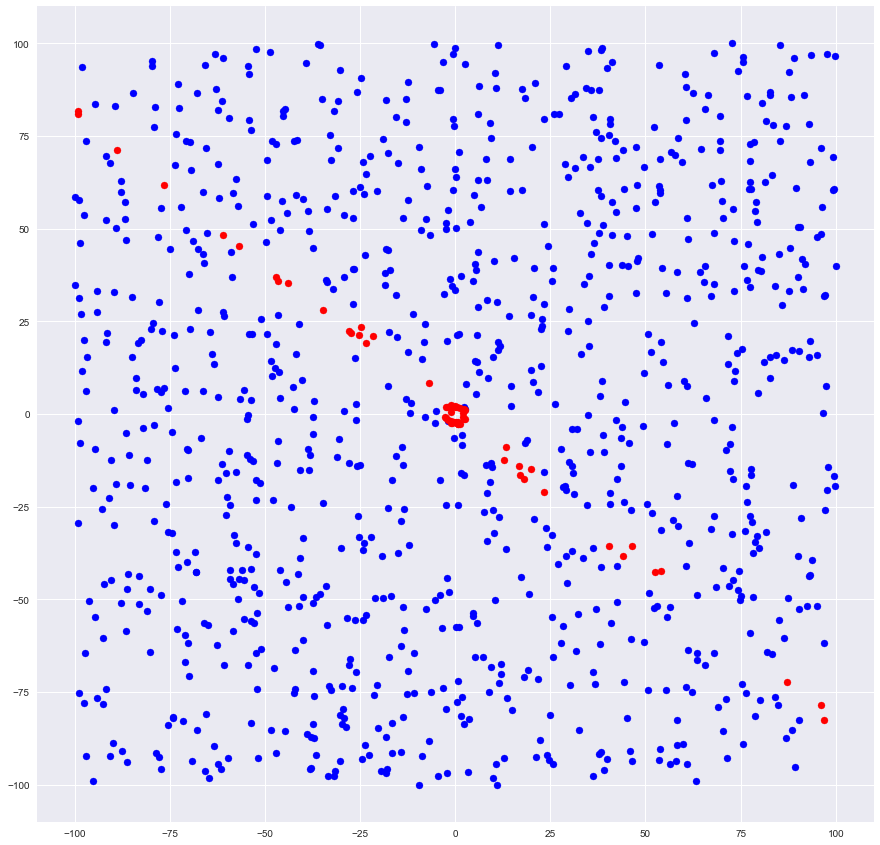

In [26]:

targets_1 = testB[testB["results"] == 1]
targets_neg_1 = testB[testB["results"] != 1]

plt.figure(figsize=(15,15))
plt.scatter(targets_neg_1["x"],targets_neg_1["y"], c='b')
plt.scatter(targets_1["x"],targets_1["y"], c='r')

#plt.scatter(background_1["x"],background_1["y"], c='r',alpha=0.4)
#plt.scatter(background_neg_1["x"],background_neg_1["y"], c='b',alpha=0.4)



In [27]:

#targets_1 = testB[testB["results"] == 1]
#targets_neg_1 = testB[testB["results"] != 1]

#plt.figure(figsize=(20,20))
#plt.scatter(targets_neg_1["x"].transform(lambda x: abs(x)),targets_neg_1["y"].transform(lambda x: abs(x)), c='b')
#plt.scatter(targets_1["x"].transform(lambda x: abs(x)),targets_1["y"].transform(lambda x: abs(x)), c='r')

#plt.scatter(background_1["x"],background_1["y"], c='r',alpha=0.4)
#plt.scatter(background_neg_1["x"],background_neg_1["y"], c='b',alpha=0.4)

